In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt

In [2]:
# Load pre-trained word2vec embeddings
embeddings_path = 'GoogleNews-vectors-negative300.bin.gz'
word_vectors = KeyedVectors.load_word2vec_format(embeddings_path, binary=True)

In [3]:
with open("train_text.txt", "r", encoding="utf-8") as f:
    train_text = f.readlines()

with open("train_labels.txt", "r", encoding="utf-8") as f:
    train_labels = f.readlines()

with open("val_text.txt", "r", encoding="utf-8") as f:
    val_text = f.readlines()

with open("val_labels.txt", "r", encoding="utf-8") as f:
    val_labels = f.readlines()

with open("test_text.txt", "r", encoding="utf-8") as f:
    test_text = f.readlines()

with open("test_labels.txt", "r", encoding="utf-8") as f:
    test_labels = f.readlines()

In [4]:
# Truncate lists to the minimum length
min_train_len = min(len(train_text), len(train_labels))
min_val_len = min(len(val_text), len(val_labels))
min_test_len = min(len(test_text), len(test_labels))

train_text, train_labels = train_text[:min_train_len], train_labels[:min_train_len]
val_text, val_labels = val_text[:min_val_len], val_labels[:min_val_len]
test_text, test_labels = test_text[:min_test_len], test_labels[:min_test_len]

In [5]:
# Prepare data
data = pd.DataFrame({"text": train_text + val_text + test_text,
                     "labels": train_labels + val_labels + test_labels})

# Convert labels to int
data["labels"] = data["labels"].astype(int)

In [6]:
def tweet2vec(tweet, word_vectors, max_len=50):
    embeddings = []
    for word in tweet.split():
        if word in word_vectors:
            embeddings.append(torch.tensor(word_vectors[word]))
        if len(embeddings) == max_len:
            break
    while len(embeddings) < max_len:
        embeddings.append(torch.zeros(300))
    return torch.stack(embeddings)

In [7]:
class TweetDataset(Dataset):
    def __init__(self, data, word_vectors):
        self.data = data
        self.word_vectors = word_vectors

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tweet = self.data.iloc[idx]["text"]
        label = self.data.iloc[idx]["labels"]
        embeddings = tweet2vec(tweet, self.word_vectors)
        return embeddings, label

In [8]:
class TextClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = x.mean(dim=1)
        out = self.fc1(embedded)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [9]:
embedding_dim = 300
hidden_dim = 128
output_dim = 3
learning_rate = 0.001
epochs = 30 
batch_size = 64  
accumulation_steps = 4 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Training and cross-validation
skf = StratifiedKFold(n_splits=5)
for train_index, val_index in skf.split(data["text"], data["labels"]):
    train_data = data.iloc[train_index]
    val_data = data.iloc[val_index]

    train_dataset = TweetDataset(train_data, word_vectors)
    val_dataset = TweetDataset(val_data, word_vectors)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    model = TextClassifier(embedding_dim, hidden_dim, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  
    training_losses = []
    validation_accuracies = []
    for epoch in range(epochs):
        
        model.train()
        running_loss = 0.0
        optimizer.zero_grad() 
        for i, (embeddings, labels) in enumerate(train_loader):
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings)

            loss = criterion(outputs, labels.long())

            loss.backward()
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item()
        training_losses.append(running_loss / len(train_loader))
        scheduler.step()
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = model(embeddings.float())

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        validation_accuracies.append(accuracy)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}, Validation accuracy: {accuracy:.2f}%")

Epoch: 10, Loss: 0.9475, Validation accuracy: 58.00%
Epoch: 20, Loss: 0.9456, Validation accuracy: 57.95%
Epoch: 30, Loss: 0.9454, Validation accuracy: 58.04%
Epoch: 10, Loss: 0.9496, Validation accuracy: 57.88%
Epoch: 20, Loss: 0.9477, Validation accuracy: 58.09%
Epoch: 30, Loss: 0.9475, Validation accuracy: 58.16%


In [11]:
class TweetDataset(Dataset):
    def __init__(self, data, word_vectors):
        self.data = data
        self.word_vectors = word_vectors

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tweet = self.data.iloc[idx]["text"]
        label = self.data.iloc[idx]["labels"]
        embeddings = tweet2vec(tweet, self.word_vectors)
        return embeddings, torch.tensor(label)

In [12]:
test_data = pd.DataFrame({"text": test_text, "labels": [int(label) for label in test_labels]})
test_dataset = TweetDataset(test_data, word_vectors)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [13]:
# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = model(embeddings.float())
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [14]:
# Confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions))
print("\nClassification Report:")
print(classification_report(true_labels, predictions, zero_division=1))

Confusion Matrix:
[[   0 3596  376]
 [   0 5219  718]
 [   0 1121 1254]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      3972
           1       0.53      0.88      0.66      5937
           2       0.53      0.53      0.53      2375

    accuracy                           0.53     12284
   macro avg       0.69      0.47      0.40     12284
weighted avg       0.68      0.53      0.42     12284



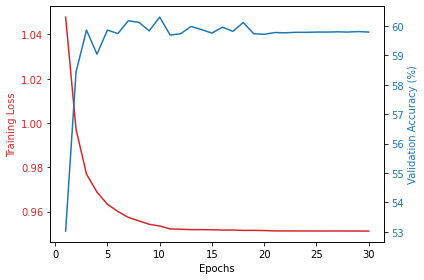

In [15]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(range(1, epochs + 1), training_losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (%)', color=color)
ax2.plot(range(1, epochs + 1), validation_accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()